In [1]:
import numpy as np
import cv2
import torch
import json
import matplotlib.pyplot as plt

# Read image and segmented area

In [2]:
# image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg")
# image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.rf.f6b63d3d61757bb631819d5e228ffe1f.jpg")


# #- read json file
# with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_2_0070_jpeg.json") as f:
#     data = json.load(f)

image_org = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")
image_seg = cv2.imread("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg")

#- read json file
with open("/Users/holmes/Documents/UNI-Bamberg/4.Semester_MA/Masterthesis/xAI_Masterthesis_Pan/Code/Transformation/test_Model_14_0013_jpeg.json") as f:
    data = json.load(f)

    
seg_output = data
class_map = {1: "other", 2: "main_beam"}

print(seg_output)


{'file_name': '/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/valid/Model_14_0013_jpeg.rf.bab0f2a77774acd744a9c7b5b864a6b5.jpg', 'instances': [{'class': 2, 'box': [352.7164001464844, 13.114960670471191, 615.6570434570312, 1024.0], 'score': 0.9999535083770752, 'mask': [{'polygon': [[441, 889], [441, 891], [440, 892], [440, 895], [439, 896], [439, 898], [440, 899], [440, 902], [441, 903], [441, 905], [442, 905], [442, 902], [443, 901], [443, 893], [442, 892], [442, 889]]}, {'polygon': [[376, 14], [375, 15], [371, 15], [370, 16], [367, 16], [366, 17], [364, 17], [363, 18], [362, 18], [361, 19], [360, 19], [359, 20], [358, 20], [357, 21], [357, 23], [356, 24], [356, 27], [355, 28], [355, 53], [356, 54], [356, 69], [357, 70], [357, 73], [358, 74], [358, 75], [361, 78], [361, 79], [364, 82], [364, 83], [367, 86], [367, 87], [368, 88], [368, 89], [369, 90], [369, 91], [370, 92], [370, 93], [371, 94], [371, 96], [372, 97], [372, 99], [373, 100], [373, 102], [

# Select main area

## select max area

In [3]:
#FUNCTION: Select the mask with the largest area using Shoelace formula

def polygon_area(polygon):
    polygon = np.array(polygon)
    x = polygon[:, 0]
    y = polygon[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    
max_area = 0
max_area_index = -1

for i, instance in enumerate(seg_output['instances']):
    polygons = instance['mask']
    for j, polygon_data in enumerate(polygons):
        polygon = polygon_data['polygon']
        area = polygon_area(polygon)
        print(f"Mask_{i}_{j} area: {area}")
        if area > max_area:
            max_area = area
            max_area_index = f"Mask_{i}_{j}"
            max_polygon = polygon

print(f"Largest mask index: {max_area_index}, area: {max_area}")

largest_polygon = max_polygon
print(largest_polygon)

Mask_0_0 area: 39.0
Mask_0_1 area: 39588.5
Mask_1_0 area: 143041.5
Mask_2_0 area: 31715.0
Mask_3_0 area: 143334.0
Largest mask index: Mask_3_0, area: 143334.0
[[199, 2], [198, 3], [191, 3], [188, 6], [188, 7], [186, 9], [186, 10], [185, 11], [185, 13], [184, 14], [184, 15], [183, 16], [183, 18], [182, 19], [182, 22], [183, 23], [183, 38], [184, 39], [184, 56], [185, 57], [185, 60], [186, 61], [186, 63], [187, 64], [187, 66], [188, 67], [188, 69], [189, 70], [189, 71], [190, 72], [190, 73], [192, 75], [192, 76], [193, 77], [193, 78], [194, 79], [194, 81], [195, 82], [195, 83], [196, 84], [196, 87], [197, 88], [197, 91], [198, 92], [198, 97], [199, 98], [199, 103], [200, 104], [200, 108], [201, 109], [201, 113], [202, 114], [202, 117], [203, 118], [203, 121], [204, 122], [204, 124], [205, 125], [205, 127], [206, 128], [206, 129], [207, 130], [207, 132], [208, 133], [208, 134], [209, 135], [209, 136], [210, 137], [210, 139], [211, 140], [211, 141], [212, 142], [212, 144], [213, 145], [213

## Plot original polygon

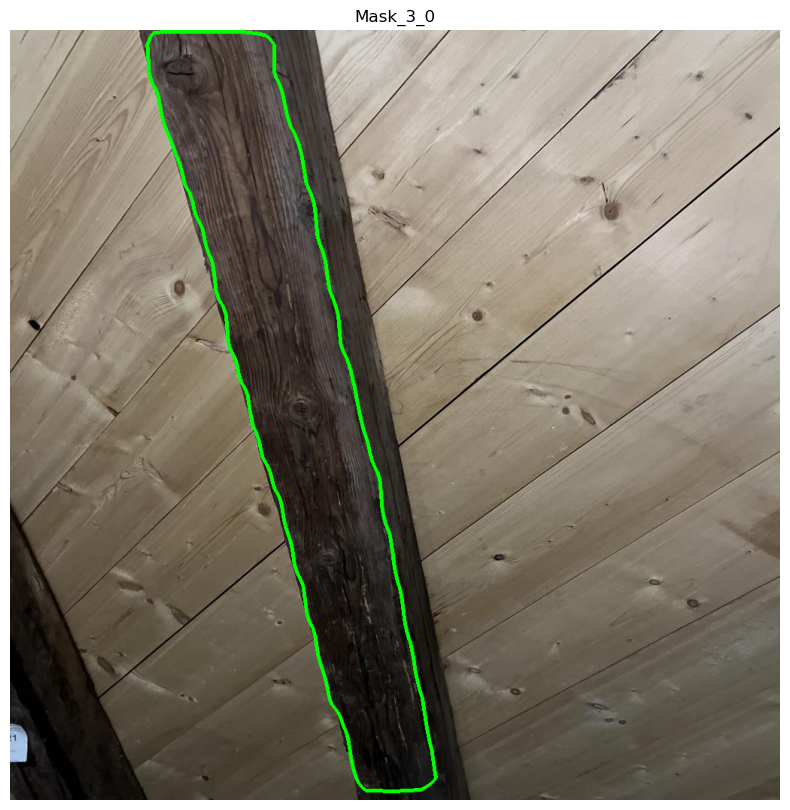

In [4]:
def draw_polygon_on_image(image, polygon):
    pts = np.array(polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=3)
    return image

image_with_polygon = draw_polygon_on_image(image_org.copy(), largest_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))
plt.title(max_area_index)
plt.axis('off')
plt.show()

# plt.imsave("image_with_largest_polygon.jpg", cv2.cvtColor(image_with_polygon, cv2.COLOR_BGR2RGB))


# Abstract complex polygon from the main area to simple polygon

In [5]:
def draw_simple_polygon(image, simplified_polygon):
    pts = np.array(simplified_polygon, np.int32)
    if pts.shape[-1] == 1:
        pts = pts.reshape((-1, 2))
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=3) 
    return image

## Simplify polygon using **Douglas-Peucker**

Simplified polygon using Douglas-Peucker algorithm:
[[[ 191    3]]

 [[ 185   60]]

 [[ 473 1011]]

 [[ 546 1010]]

 [[ 566  992]]

 [[ 492  600]]

 [[ 351   19]]

 [[ 322    3]]]


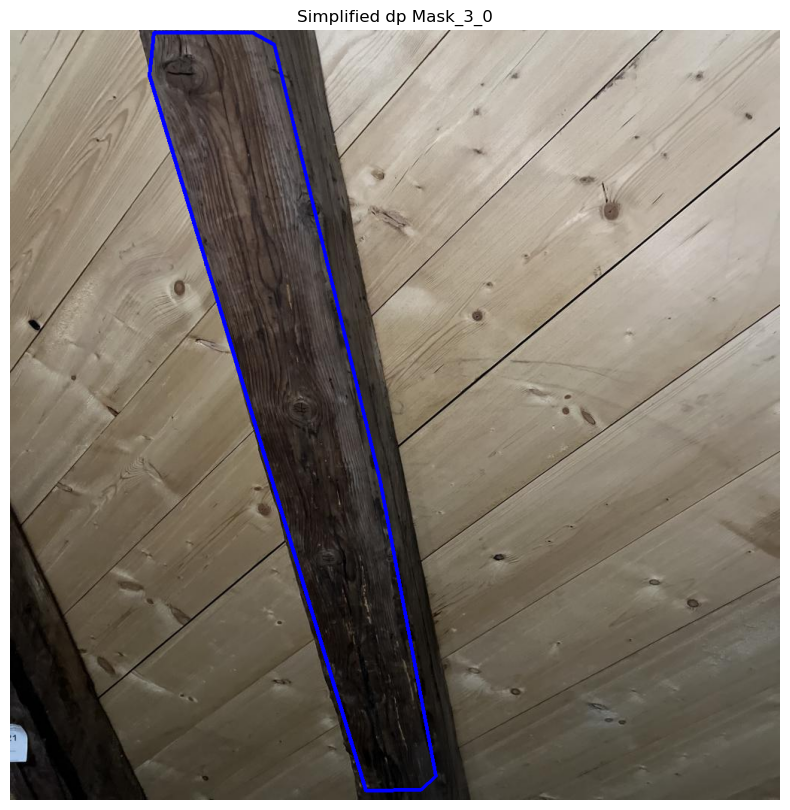

In [7]:
# FUNCTION: Simplify the polygon using Douglas-Peucker algorithm

def dp_simplify(polygon, epsilon_factor=0.005):
    contour = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    epsilon = epsilon_factor * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

dp_simplified_polygon = dp_simplify(largest_polygon)

print("Simplified polygon using Douglas-Peucker algorithm:")
print(dp_simplified_polygon)

image_with_dp_polygon = draw_simple_polygon(image_org.copy(), dp_simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"Simplified dp {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_dp_polygon.jpg", cv2.cvtColor(image_with_dp_polygon, cv2.COLOR_BGR2RGB))



## Simplify polygon using **Visvalingam–Whyatt**

Simplified polygon using Visvalingam–Whyatt algorithm:
[[199.   2.]
 [198.   3.]
 [191.   3.]
 ...
 [322.   3.]
 [313.   3.]
 [312.   2.]]


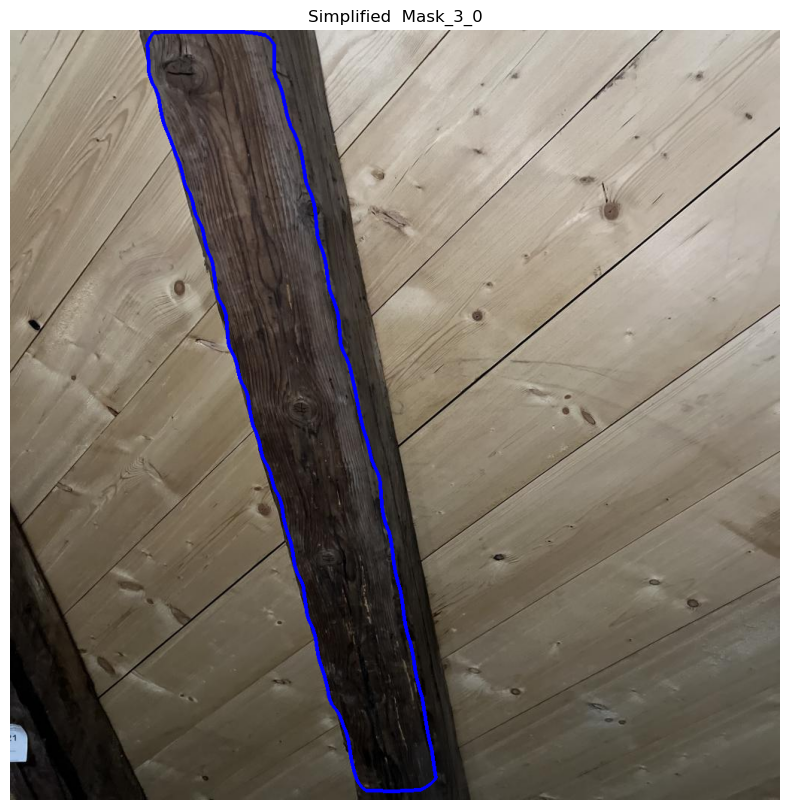

In [16]:
# FUNCTION: Simplified polygon using Visvalingam–Whyatt algorithm

def vw_simplify(polygon, threshold=0.5):
    def area_of_triangle(p1, p2, p3):
        return 0.5 * abs(p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))
    
    points = np.array(polygon, dtype=np.float32)
    is_removed = np.zeros(points.shape[0], dtype=bool)
    areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
    
    while len(areas) > 0 and np.min(areas) < threshold:
        min_index = np.argmin(areas) + 1
        is_removed[min_index] = True
        points = points[~is_removed]
        print(f"Removed point at index {min_index}, remaining points: {len(points)}")
        if len(points) < 3:
            break
        areas = np.array([area_of_triangle(points[i - 1], points[i], points[i + 1]) for i in range(1, len(points) - 1)])
        print(f"Recomputed areas: {areas}")
    return points

vw_simplified_polygon = vw_simplify(largest_polygon)

print("Simplified polygon using Visvalingam–Whyatt algorithm:")
print(vw_simplified_polygon)

image_with_vw_polygon = draw_simple_polygon(image_org.copy(), vw_simplified_polygon)


plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))
plt.title(f"Simplified  {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_with_vw_polygon.jpg", cv2.cvtColor(image_with_vw_polygon, cv2.COLOR_BGR2RGB))


### Plot simplify polygon

## Simplify polygon using **convex_hull**

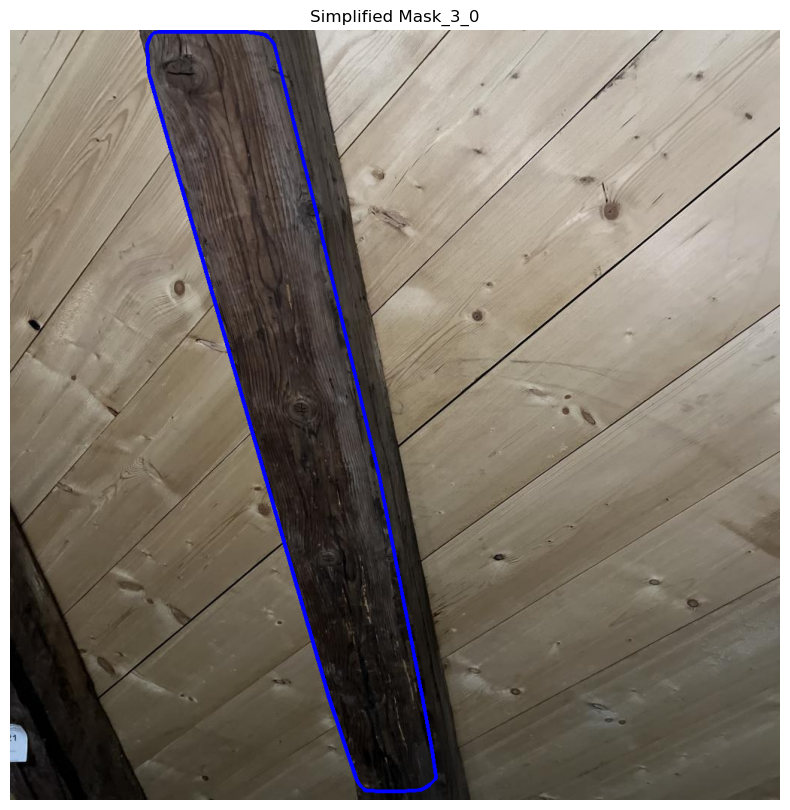

In [17]:
#FUNCTION: convex_hull

def ch_simplify(polygon):
    points = np.array(polygon, dtype=np.int32).reshape((-1, 1, 2))
    hull = cv2.convexHull(points)
    return hull

# simplified_polygon = ch_simplify(dp_simplified_polygon)
simplified_polygon = ch_simplify(vw_simplified_polygon)

# print(simplified_polygon)

image_after_ch = draw_simple_polygon(image_org.copy(), simplified_polygon)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))
plt.title(f"Simplified {max_area_index}")
plt.axis('off')
plt.show()

# plt.imsave("image_after_ch.jpg", cv2.cvtColor(image_after_ch, cv2.COLOR_BGR2RGB))



# Reshape the simple polygon to parallel pairs/correct perspective

In [ ]:
# FUNCTION: Simplified polygon using Ramer-Douglas-Peucker algorithm

simplified_polygon

In [ ]:
# 逼近轮廓
def myApprox(con, epsilon_factor=0.01):
    epsilon = epsilon_factor * cv2.arcLength(con, True)
    approx = cv2.approxPolyDP(con, epsilon, True)
    return approx

# 多边形矫正
def Polygon_correction(img):
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    ori_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    ori_h, ori_w = ori_img.shape[:2]
    print('ori_w, ori_h:', ori_w, ori_h)

    cv2.imshow('binary', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if len(contours) > 0:
        cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
        docCnt = None

        for cnt in cnts:
            approx = myApprox(cnt)
            if len(approx) >= 4:
                docCnt = approx
                break

        if docCnt is not None:
            rect = cv2.minAreaRect(docCnt)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            src_points = np.float32(box)
            dst_points = np.float32([[0, 0], [0, ori_h - 1], [ori_w - 1, ori_h - 1], [ori_w - 1, 0]])

            M = cv2.getPerspectiveTransform(src_points, dst_points)
            result = cv2.warpPerspective(ori_img, M, (ori_w, ori_h))

            for point in box:
                cv2.circle(result, tuple(point), 5, (0, 255, 0), 2)

            print("原始点:", src_points)
            print("变换后的点：", dst_points)

            cv2.polylines(result, [box], True, (255, 255, 0), 2)
            cv2.imshow('result', result)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
            return result
        else:
            return img
    else:
        return img

# 测试代码
# img = cv2.imread('your_image_path_here')
# Polygon_correction(img)


# Export results

In [ ]:
import matplotlib.pyplot as plt

def export_results(original_image, transformed_image, transformed_contour):
    plt.figure(figsize=(10, 5))
    
    # # show the original image
    # plt.subplot(1, 2, 1)
    # plt.title("Original Image")
    # plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    
    # # show the transformed image
    # plt.subplot(1, 2, 2)
    # plt.title("Transformed Image")
    # plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    
    # plot the contour
    for pt in transformed_contour:
        plt.scatter(pt[0], pt[1], c='red')
    
    plt.show()

export_results(image, transformed_image, transformed_contour)


# 